# ETF Feature EDA Notebook (Daily)

This notebook helps to **understand** the engineered technical indicators and data quality.

**Goals**
- Check data coverage per ticker and time
- Understand missing values (rolling-window warmup)
- Visualize price + key indicators
- Compare ETFs cross-sectionally (risk vs performance)
- Produce a clean dataset ready for ranking or ML


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

CSV_PATH = Path('output.csv')

pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 200)


In [5]:
# Load
df = pd.read_csv(CSV_PATH)
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.sort_values(['ticker','date']).reset_index(drop=True)

print('Rows:', len(df))
print('Tickers:', df['ticker'].nunique())
df.head()

Rows: 20290
Tickers: 10


,ticker,date,open,high,low,close,volume,returns_1d,returns_21d,returns_63d,log_returns_1d,high_low_range,close_open_change,sma_10,ema_10,price_vs_sma_10,price_vs_ema_10,sma_20,ema_20,price_vs_sma_20,price_vs_ema_20,sma_50,ema_50,price_vs_sma_50,price_vs_ema_50,sma_100,ema_100,price_vs_sma_100,price_vs_ema_100,sma_200,ema_200,price_vs_sma_200,price_vs_ema_200,rsi_14,rsi_21,rsi_28,stoch_k,stoch_d,roc_10,roc_20,roc_63,macd,macd_signal,macd_diff,adx_14,adx_20,sma_20_above_50,sma_20_50_diff,sma_50_above_200,sma_50_200_diff,volatility_20,volatility_30,volatility_60,volatility_126,bb_20_upper,bb_20_lower,bb_20_middle,bb_20_position,bb_20_width,bb_30_upper,bb_30_lower,bb_30_middle,bb_30_position,bb_30_width,atr_14,atr_14_pct,atr_21,atr_21_pct,volume_sma_20,volume_ratio_20,volume_sma_50,volume_ratio_50,volume_sma_100,volume_ratio_100,obv,obv_sma_20,obv_trend,cmf_20,drawdown,max_drawdown_63,max_drawdown_126,max_drawdown_252,trend_persistence_63,trend_persistence_126,trend_persistence_252
0,BND,2018-01-02,81.449997,81.500000,81.220001,81.339996,3104500.0,NaN,NaN,NaN,NaN,0.003442,-0.001351,NaN,81.339996,NaN,0.000000,NaN,81.339996,NaN,0.000000,NaN,81.339996,NaN,0.000000,NaN,81.339996,NaN,0.000000,NaN,81.339996,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,3104500.0,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
1,BND,2018-01-03,81.430000,81.430000,81.290001,81.410004,2216700.0,0.000861,NaN,NaN,0.000860,0.001720,-0.000246,NaN,81.352725,NaN,0.000704,NaN,81.346664,NaN,0.000779,NaN,81.342742,NaN,0.000827,NaN,81.341383,NaN,0.000844,NaN,81.340693,NaN,0.000852,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,5321200.0,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
2,BND,2018-01-04,81.330002,81.370003,81.250000,81.370003,2152400.0,-0.000491,NaN,NaN,-0.000491,0.001475,0.000492,NaN,81.355866,NaN,0.000174,NaN,81.348886,NaN,0.000260,NaN,81.343811,NaN,0.000322,NaN,81.341949,NaN,0.000345,NaN,81.340985,NaN,0.000357,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,3168800.0,NaN,NaN,NaN,-0.000491,NaN,NaN,NaN,NaN,NaN,NaN
3,BND,2018-01-05,81.349998,81.360001,81.199997,81.260002,4257400.0,-0.001352,NaN,NaN,-0.001353,0.001969,-0.001106,NaN,81.338437,NaN,-0.000964,NaN,81.340421,NaN,-0.000989,NaN,81.340524,NaN,-0.000990,NaN,81.340327,NaN,-0.000988,NaN,81.340179,NaN,-0.000986,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,-1088600.0,NaN,NaN,NaN,-0.001843,NaN,NaN,NaN,NaN,NaN,NaN
4,BND,2018-01-08,81.330002,81.330002,81.209999,81.269997,2587300.0,0.000123,NaN,NaN,0.000123,0.001477,-0.000738,NaN,81.325993,NaN,-0.000689,NaN,81.333714,NaN,-0.000783,NaN,81.337758,NaN,-0.000833,NaN,81.338934,NaN,-0.000848,NaN,81.339480,NaN,-0.000854,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1498700.0,NaN,NaN,NaN,-0.001720,NaN,NaN,NaN,NaN,NaN,NaN


## 1) Quick schema + sanity checks

In [6]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 20290 entries, 0 to 20289
Data columns (total 85 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   ticker                 20290 non-null  str           
 1   date                   20290 non-null  datetime64[us]
 2   open                   20290 non-null  float64       
 3   high                   20290 non-null  float64       
 4   low                    20290 non-null  float64       
 5   close                  20290 non-null  float64       
 6   volume                 20290 non-null  float64       
 7   returns_1d             20280 non-null  float64       
 8   returns_21d            20080 non-null  float64       
 9   returns_63d            19660 non-null  float64       
 10  log_returns_1d         20280 non-null  float64       
 11  high_low_range         20290 non-null  float64       
 12  close_open_change      20290 non-null  float64       
 13  sma_10      

In [7]:
# Basic sanity: duplicates and monotonic dates per ticker
dupes = df.duplicated(['ticker','date']).sum()
print('Duplicate (ticker,date) rows:', dupes)

# Per ticker: min/max date and row counts
coverage = df.groupby('ticker').agg(
    start=('date','min'),
    end=('date','max'),
    n=('date','count')
).sort_values('n', ascending=False)
coverage.head(20)

Duplicate (ticker,date) rows: 0


,start,end,n
ticker,,,
BND,2018-01-02,2026-01-29,2030
SCHD,2018-01-02,2026-01-29,2030
SPLV,2018-01-02,2026-01-29,2030
SPY,2018-01-02,2026-01-29,2030
VTI,2018-01-02,2026-01-29,2030
VCN.TO,2018-01-02,2026-01-29,2028
VDY.TO,2018-01-02,2026-01-29,2028
VFV.TO,2018-01-02,2026-01-29,2028
XIC.TO,2018-01-02,2026-01-29,2028


## 2) Missing values

Many indicators use rolling windows (e.g., SMA-200). The first ~199 rows per ticker will be missing for those.


In [8]:
# Missingness by column (top 30)
na_rate = df.isna().mean().sort_values(ascending=False)
na_rate.head(30)

max_drawdown_252         0.123706
trend_persistence_252    0.123706
price_vs_sma_200         0.098078
sma_200                  0.098078
sma_50_200_diff          0.098078
volatility_126           0.062100
trend_persistence_126    0.061607
max_drawdown_126         0.061607
sma_100                  0.048793
price_vs_sma_100         0.048793
volume_sma_100           0.048793
volume_ratio_100         0.048793
roc_63                   0.031050
returns_63d              0.031050
trend_persistence_63     0.030557
max_drawdown_63          0.030557
volatility_60            0.029571
sma_50                   0.024150
volume_sma_50            0.024150
price_vs_sma_50          0.024150
sma_20_50_diff           0.024150
volume_ratio_50          0.024150
adx_20                   0.019221
macd_diff                0.016264
macd_signal              0.016264
volatility_30            0.014786
bb_30_middle             0.014293
bb_30_width              0.014293
bb_30_position           0.014293
bb_30_lower   

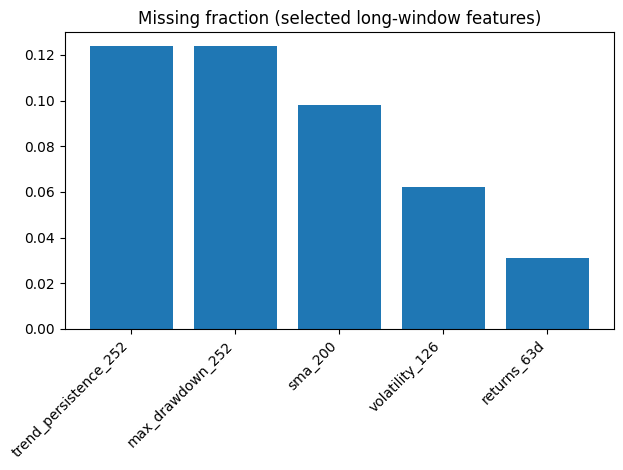

In [ ]:
# Visualize missingness for key long-window columns
# NOTE: To show how often certain columns are missing
cols = [
    'returns_63d','sma_200','volatility_126','max_drawdown_252','trend_persistence_252'
]
cols = [c for c in cols if c in df.columns]
miss = df[cols].isna().mean().sort_values(ascending=False)
plt.figure()
plt.bar(miss.index, miss.values)
plt.xticks(rotation=45, ha='right')
plt.title('Missing fraction (selected long-window features)')
plt.tight_layout()
plt.show()

**INTERPRETATION**

- ~12% missing for 252-day features -> totally expected
- ~3% missing for 63-day returns -> makes sense (shorter window)

**ACTION**

- For EDA -> Let it be
- For modeling -> Drop early rows where these aren't available

## 3) Choose a ticker to visualize

Pick one ETF and inspect price + indicators over time.


In [ ]:
tickers = df['ticker'].dropna().unique()
ticker = tickers[0]  # change to any ticker
d = df[df['ticker'] == ticker].copy()
d = d.sort_values('date')
print('Selected:', ticker, 'rows:', len(d), 'range:', d['date'].min(), '->', d['date'].max())
d.head()

Selected: BND rows: 2030 range: 2018-01-02 00:00:00 -> 2026-01-29 00:00:00


,ticker,date,open,high,low,close,volume,returns_1d,returns_21d,returns_63d,log_returns_1d,high_low_range,close_open_change,sma_10,ema_10,price_vs_sma_10,price_vs_ema_10,sma_20,ema_20,price_vs_sma_20,price_vs_ema_20,sma_50,ema_50,price_vs_sma_50,price_vs_ema_50,sma_100,ema_100,price_vs_sma_100,price_vs_ema_100,sma_200,ema_200,price_vs_sma_200,price_vs_ema_200,rsi_14,rsi_21,rsi_28,stoch_k,stoch_d,roc_10,roc_20,roc_63,macd,macd_signal,macd_diff,adx_14,adx_20,sma_20_above_50,sma_20_50_diff,sma_50_above_200,sma_50_200_diff,volatility_20,volatility_30,volatility_60,volatility_126,bb_20_upper,bb_20_lower,bb_20_middle,bb_20_position,bb_20_width,bb_30_upper,bb_30_lower,bb_30_middle,bb_30_position,bb_30_width,atr_14,atr_14_pct,atr_21,atr_21_pct,volume_sma_20,volume_ratio_20,volume_sma_50,volume_ratio_50,volume_sma_100,volume_ratio_100,obv,obv_sma_20,obv_trend,cmf_20,drawdown,max_drawdown_63,max_drawdown_126,max_drawdown_252,trend_persistence_63,trend_persistence_126,trend_persistence_252
0,BND,2018-01-02,81.449997,81.500000,81.220001,81.339996,3104500.0,NaN,NaN,NaN,NaN,0.003442,-0.001351,NaN,81.339996,NaN,0.000000,NaN,81.339996,NaN,0.000000,NaN,81.339996,NaN,0.000000,NaN,81.339996,NaN,0.000000,NaN,81.339996,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,3104500.0,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
1,BND,2018-01-03,81.430000,81.430000,81.290001,81.410004,2216700.0,0.000861,NaN,NaN,0.000860,0.001720,-0.000246,NaN,81.352725,NaN,0.000704,NaN,81.346664,NaN,0.000779,NaN,81.342742,NaN,0.000827,NaN,81.341383,NaN,0.000844,NaN,81.340693,NaN,0.000852,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,5321200.0,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
2,BND,2018-01-04,81.330002,81.370003,81.250000,81.370003,2152400.0,-0.000491,NaN,NaN,-0.000491,0.001475,0.000492,NaN,81.355866,NaN,0.000174,NaN,81.348886,NaN,0.000260,NaN,81.343811,NaN,0.000322,NaN,81.341949,NaN,0.000345,NaN,81.340985,NaN,0.000357,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,3168800.0,NaN,NaN,NaN,-0.000491,NaN,NaN,NaN,NaN,NaN,NaN
3,BND,2018-01-05,81.349998,81.360001,81.199997,81.260002,4257400.0,-0.001352,NaN,NaN,-0.001353,0.001969,-0.001106,NaN,81.338437,NaN,-0.000964,NaN,81.340421,NaN,-0.000989,NaN,81.340524,NaN,-0.000990,NaN,81.340327,NaN,-0.000988,NaN,81.340179,NaN,-0.000986,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,-1088600.0,NaN,NaN,NaN,-0.001843,NaN,NaN,NaN,NaN,NaN,NaN
4,BND,2018-01-08,81.330002,81.330002,81.209999,81.269997,2587300.0,0.000123,NaN,NaN,0.000123,0.001477,-0.000738,NaN,81.325993,NaN,-0.000689,NaN,81.333714,NaN,-0.000783,NaN,81.337758,NaN,-0.000833,NaN,81.338934,NaN,-0.000848,NaN,81.339480,NaN,-0.000854,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1498700.0,NaN,NaN,NaN,-0.001720,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
ticker = tickers[1]  # change to any ticker
d = df[df['ticker'] == ticker].copy()
d = d.sort_values('date')
print('Selected:', ticker, 'rows:', len(d), 'range:', d['date'].min(), '->', d['date'].max())
d.head()

Selected: SCHD rows: 2030 range: 2018-01-02 00:00:00 -> 2026-01-29 00:00:00


,ticker,date,open,high,low,close,volume,returns_1d,returns_21d,returns_63d,log_returns_1d,high_low_range,close_open_change,sma_10,ema_10,price_vs_sma_10,price_vs_ema_10,sma_20,ema_20,price_vs_sma_20,price_vs_ema_20,sma_50,ema_50,price_vs_sma_50,price_vs_ema_50,sma_100,ema_100,price_vs_sma_100,price_vs_ema_100,sma_200,ema_200,price_vs_sma_200,price_vs_ema_200,rsi_14,rsi_21,rsi_28,stoch_k,stoch_d,roc_10,roc_20,roc_63,macd,macd_signal,macd_diff,adx_14,adx_20,sma_20_above_50,sma_20_50_diff,sma_50_above_200,sma_50_200_diff,volatility_20,volatility_30,volatility_60,volatility_126,bb_20_upper,bb_20_lower,bb_20_middle,bb_20_position,bb_20_width,bb_30_upper,bb_30_lower,bb_30_middle,bb_30_position,bb_30_width,atr_14,atr_14_pct,atr_21,atr_21_pct,volume_sma_20,volume_ratio_20,volume_sma_50,volume_ratio_50,volume_sma_100,volume_ratio_100,obv,obv_sma_20,obv_trend,cmf_20,drawdown,max_drawdown_63,max_drawdown_126,max_drawdown_252,trend_persistence_63,trend_persistence_126,trend_persistence_252
2030,SCHD,2018-01-02,17.120001,17.123333,17.070000,17.110001,2382300.0,NaN,NaN,NaN,NaN,0.003117,-0.000584,NaN,17.110001,NaN,0.000000,NaN,17.110001,NaN,0.000000,NaN,17.110001,NaN,0.000000,NaN,17.110001,NaN,0.000000,NaN,17.110001,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2382300.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2031,SCHD,2018-01-03,17.106667,17.166668,17.073334,17.160000,2928900.0,0.002922,NaN,NaN,0.002918,0.005439,0.003118,NaN,17.119091,NaN,0.002390,NaN,17.114762,NaN,0.002643,NaN,17.111961,NaN,0.002807,NaN,17.110991,NaN,0.002864,NaN,17.110498,NaN,0.002893,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,5311200.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2032,SCHD,2018-01-04,17.173332,17.266666,17.160000,17.243334,2469900.0,0.004856,NaN,NaN,0.004845,0.006186,0.004076,NaN,17.141681,NaN,0.005930,NaN,17.127007,NaN,0.006792,NaN,17.117113,NaN,0.007374,NaN,17.113611,NaN,0.007580,NaN,17.111820,NaN,0.007686,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,7781100.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2033,SCHD,2018-01-05,17.283333,17.360001,17.250000,17.350000,2328600.0,0.006186,NaN,NaN,0.006167,0.006340,0.003857,NaN,17.179557,NaN,0.009921,NaN,17.148245,NaN,0.011765,NaN,17.126246,NaN,0.013065,NaN,17.118292,NaN,0.013536,NaN,17.114190,NaN,0.013779,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,10109700.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2034,SCHD,2018-01-08,17.340000,17.396667,17.330000,17.386667,2660400.0,0.002113,NaN,NaN,0.002111,0.003834,0.002691,NaN,17.217214,NaN,0.009842,NaN,17.170952,NaN,0.012563,NaN,17.136459,NaN,0.014601,NaN,17.123607,NaN,0.015362,NaN,17.116901,NaN,0.015760,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,12770100.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN


## 4) Price + moving averages (core visual)

This is the most important chart for medium/long horizons.


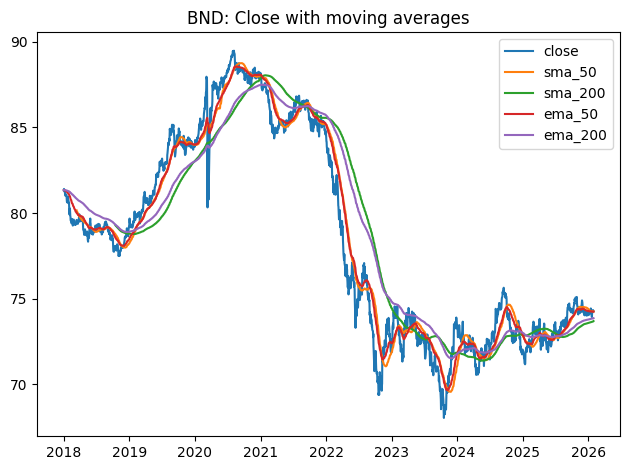

In [11]:
plt.figure()
plt.plot(d['date'], d['close'], label='close')
for c in ['sma_50','sma_200','ema_50','ema_200']:
    if c in d.columns:
        plt.plot(d['date'], d[c], label=c)
plt.title(f'{ticker}: Close with moving averages')
plt.legend()
plt.tight_layout()
plt.show()

**INTERPRETATION**

- Uptrend into ~2019-2021
- Big break around 2022
- Long and slow recovery afterward

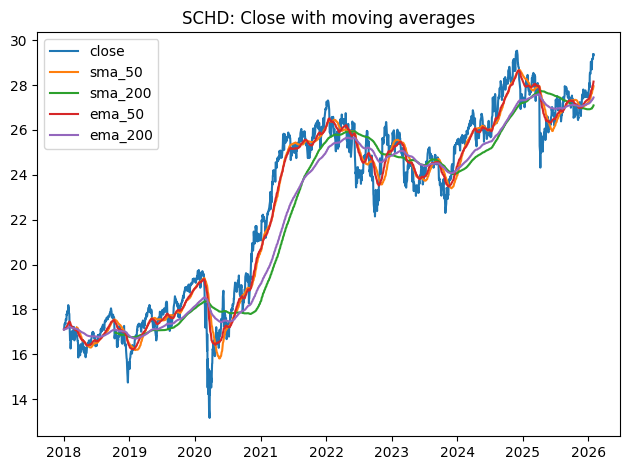

In [21]:
plt.figure()
plt.plot(d['date'], d['close'], label='close')
for c in ['sma_50','sma_200','ema_50','ema_200']:
    if c in d.columns:
        plt.plot(d['date'], d[c], label=c)
plt.title(f'{ticker}: Close with moving averages')
plt.legend()
plt.tight_layout()
plt.show()

## 5) Simple candlestick

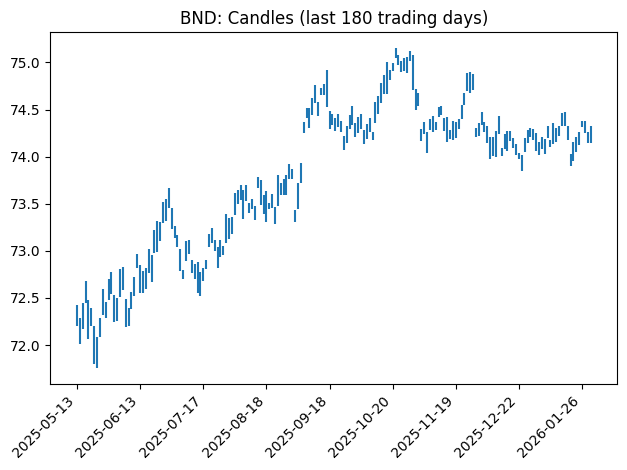

In [ ]:
def plot_candles(d, n=200):
    """Basic candlestick chart using matplotlib only."""
    x = d.dropna(subset=['open','high','low','close']).tail(n).copy()
    x = x.sort_values('date')
    xs = np.arange(len(x))

    plt.figure()
    for i, row in enumerate(x.itertuples(index=False)):
        o = row.open
        h = row.high
        l = row.low
        c = row.close
        # wick
        plt.vlines(i, l, h)
        # body
        y0 = min(o, c)
        y1 = max(o, c)
        plt.bar(i, y1 - y0, bottom=y0, width=0.6)

    plt.title(f'{ticker}: Candles (last {len(x)} trading days)')
    # Label a few dates
    step = max(1, len(x)//8)
    plt.xticks(xs[::step], x['date'].dt.strftime('%Y-%m-%d').iloc[::step], rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

plot_candles(d, n=180)

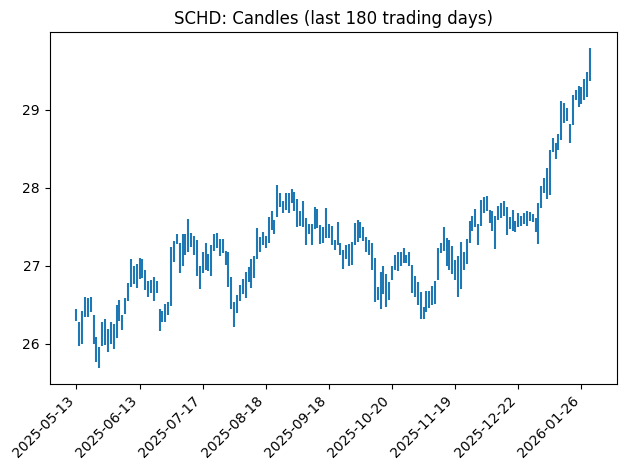

In [22]:
plot_candles(d, n=180)

## 6) Risk visuals: volatility + drawdown

- Volatility: how much it wiggles
- Drawdown: how far below its previous peak it is (downside focus)


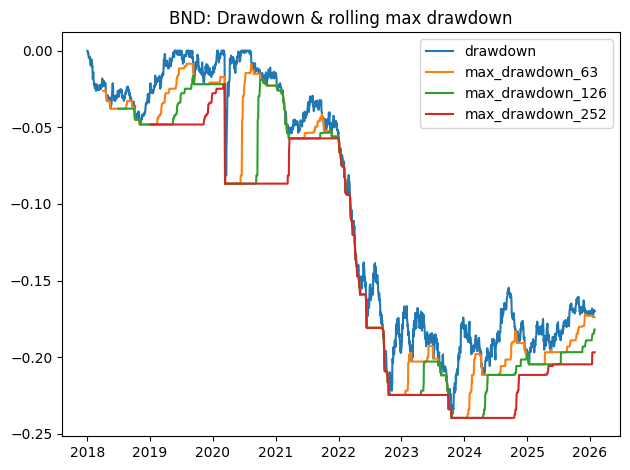

In [13]:
plt.figure()
plt.plot(d['date'], d['drawdown'], label='drawdown')
for c in ['max_drawdown_63','max_drawdown_126','max_drawdown_252']:
    if c in d.columns:
        plt.plot(d['date'], d[c], label=c)
plt.title(f'{ticker}: Drawdown & rolling max drawdown')
plt.legend()
plt.tight_layout()
plt.show()

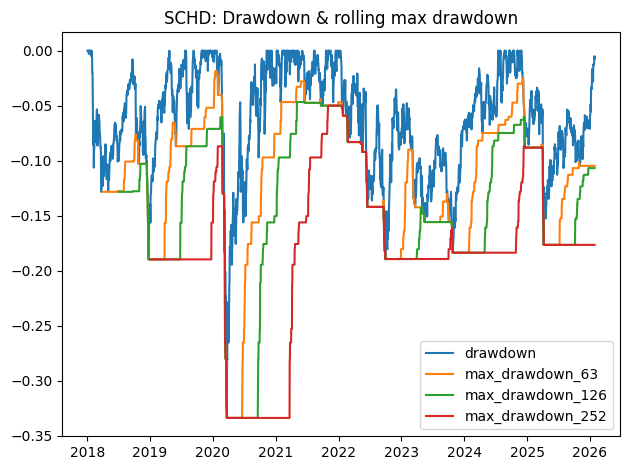

In [23]:
plt.figure()
plt.plot(d['date'], d['drawdown'], label='drawdown')
for c in ['max_drawdown_63','max_drawdown_126','max_drawdown_252']:
    if c in d.columns:
        plt.plot(d['date'], d[c], label=c)
plt.title(f'{ticker}: Drawdown & rolling max drawdown')
plt.legend()
plt.tight_layout()
plt.show()

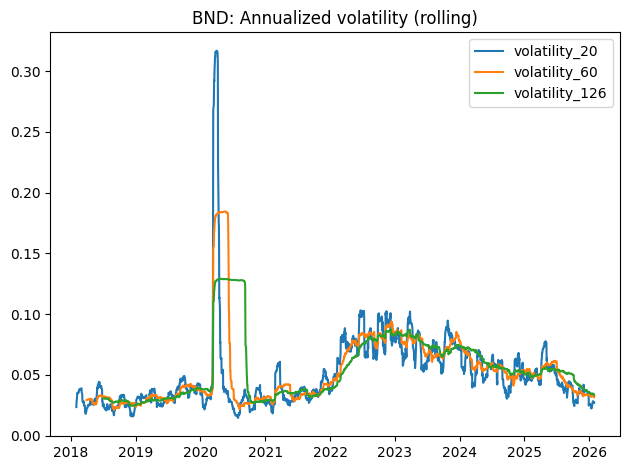

In [14]:
plt.figure()
for c in ['volatility_20','volatility_60','volatility_126']:
    if c in d.columns:
        plt.plot(d['date'], d[c], label=c)
plt.title(f'{ticker}: Annualized volatility (rolling)')
plt.legend()
plt.tight_layout()
plt.show()

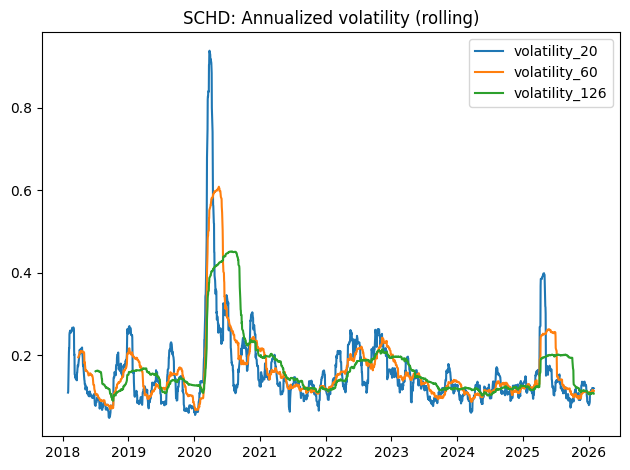

In [24]:
plt.figure()
for c in ['volatility_20','volatility_60','volatility_126']:
    if c in d.columns:
        plt.plot(d['date'], d[c], label=c)
plt.title(f'{ticker}: Annualized volatility (rolling)')
plt.legend()
plt.tight_layout()
plt.show()

## 7) Trend/momentum visuals: RSI + MACD

These show *strength* and *direction change* more than long-term value.


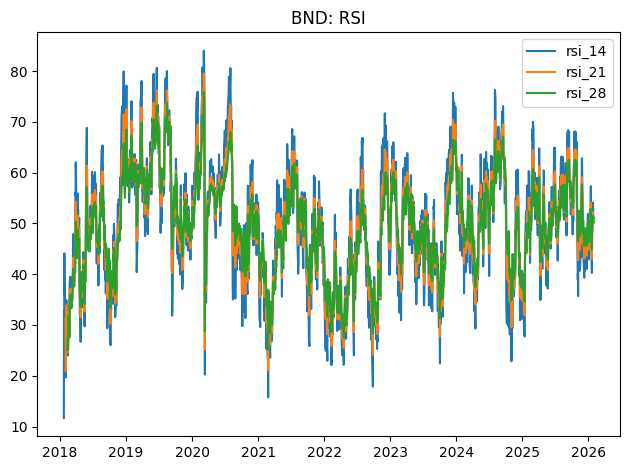

In [15]:
plt.figure()
for c in ['rsi_14','rsi_21','rsi_28']:
    if c in d.columns:
        plt.plot(d['date'], d[c], label=c)
plt.title(f'{ticker}: RSI')
plt.legend()
plt.tight_layout()
plt.show()

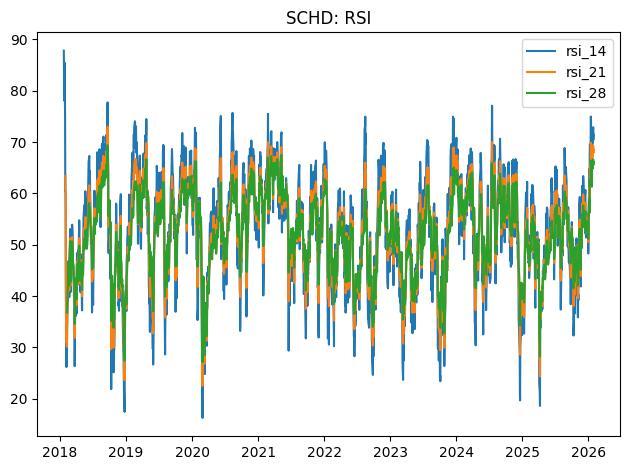

In [25]:
plt.figure()
for c in ['rsi_14','rsi_21','rsi_28']:
    if c in d.columns:
        plt.plot(d['date'], d[c], label=c)
plt.title(f'{ticker}: RSI')
plt.legend()
plt.tight_layout()
plt.show()

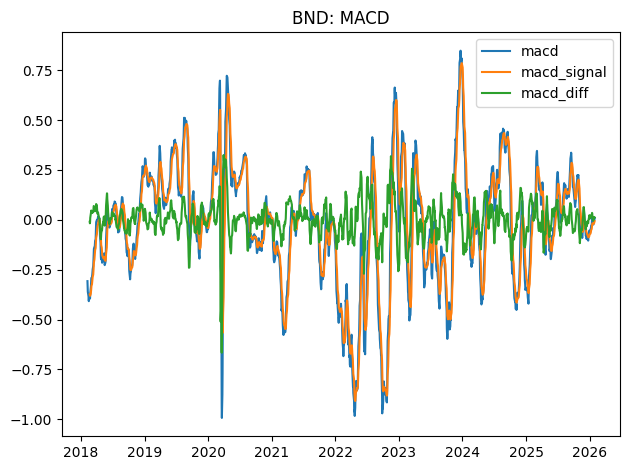

In [16]:
plt.figure()
for c in ['macd','macd_signal','macd_diff']:
    if c in d.columns:
        plt.plot(d['date'], d[c], label=c)
plt.title(f'{ticker}: MACD')
plt.legend()
plt.tight_layout()
plt.show()

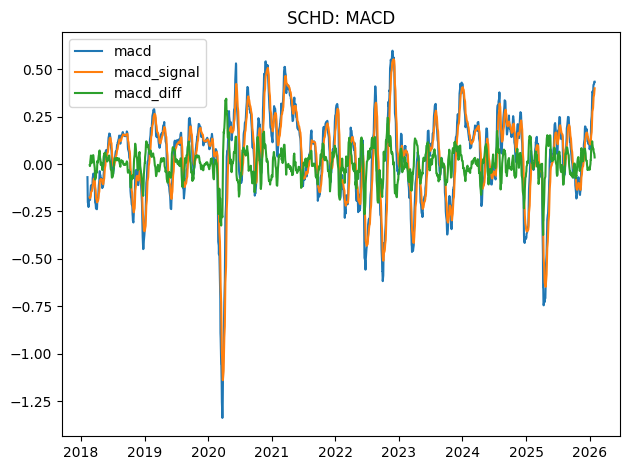

In [26]:
plt.figure()
for c in ['macd','macd_signal','macd_diff']:
    if c in d.columns:
        plt.plot(d['date'], d[c], label=c)
plt.title(f'{ticker}: MACD')
plt.legend()
plt.tight_layout()
plt.show()

## 8) Cross-sectional view: compare ETFs on a single date

Pick the latest common date and plot **risk vs performance**.


Snapshot date: 2026-01-29 00:00:00
Tickers in snapshot (after dropna): 10


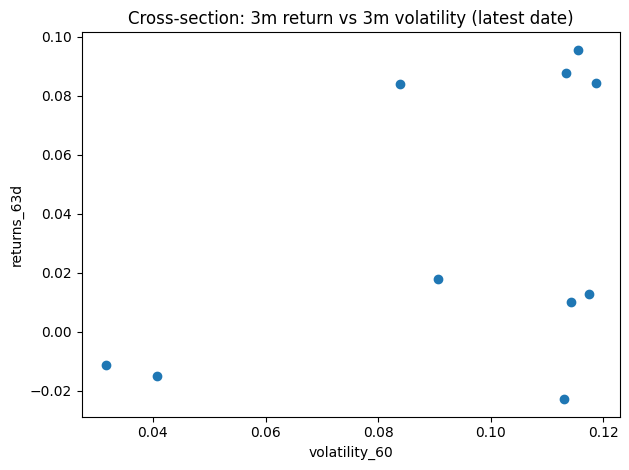

In [17]:
# Choose a date where most tickers have values
latest_date = df['date'].max()
snap = df[df['date'] == latest_date].copy()

# Keep only rows with required columns
need = ['returns_63d','volatility_60','max_drawdown_126']
need = [c for c in need if c in snap.columns]
snap2 = snap.dropna(subset=need)
print('Snapshot date:', latest_date)
print('Tickers in snapshot (after dropna):', snap2['ticker'].nunique())

plt.figure()
plt.scatter(snap2['volatility_60'], snap2['returns_63d'])
plt.title('Cross-section: 3m return vs 3m volatility (latest date)')
plt.xlabel('volatility_60')
plt.ylabel('returns_63d')
plt.tight_layout()
plt.show()

## 9) Correlation heatmap

Useful to spot redundant features before ML.


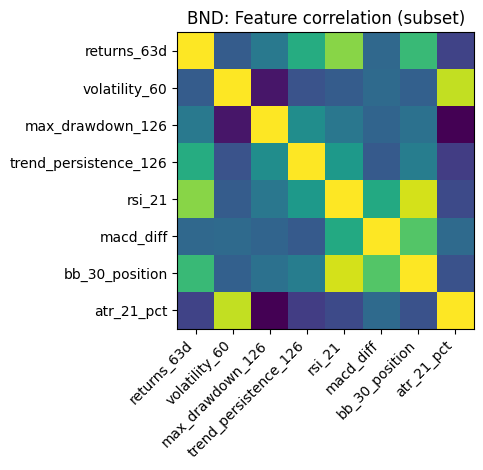

In [18]:
feature_subset = [
    'returns_63d','volatility_60','max_drawdown_126','trend_persistence_126',
    'rsi_21','macd_diff','bb_30_position','atr_21_pct'
]
feature_subset = [c for c in feature_subset if c in df.columns]

# Use one ticker to avoid mixing cross-sectional & time-series effects
d2 = df[df['ticker'] == ticker].dropna(subset=feature_subset).copy()
corr = d2[feature_subset].corr()

plt.figure()
plt.imshow(corr.values)
plt.xticks(range(len(feature_subset)), feature_subset, rotation=45, ha='right')
plt.yticks(range(len(feature_subset)), feature_subset)
plt.title(f'{ticker}: Feature correlation (subset)')
plt.tight_layout()
plt.show()

## 10) Create a clean dataset for modeling/ranking

**Rule:** For long-horizon features (e.g., 252d), drop early rows per ticker until those features exist.


In [ ]:
# Example: keep only rows where long-window features exist
required = ['returns_63d','sma_200','volatility_126','max_drawdown_252','trend_persistence_252']
required = [c for c in required if c in df.columns]

clean = df.dropna(subset=required).copy()
print('Clean rows:', len(clean), 'Tickers:', clean['ticker'].nunique())
clean.head()

In [ ]:
# Save clean dataset
clean.to_csv('output_clean_long_horizon.csv', index=False)
print('Saved: output_clean_long_horizon.csv')